### Name: Syeda Hifsa Kazmi
### Roll No. 25K-7602

## Creating Panorama of two images:





In [3]:
# Library Imports
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial import distance
from skimage import color
from skimage.feature import SIFT
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, warp
import random

In [4]:
# Utility Functions

# Normalize image for display
def normalizeImg(np_img):
  # Normalize the output image to [0, 255] range
  normalized_output = 255 * ((np_img - np.min(np_img)) /
   (np.max(np_img) - np.min(np_img)))

  return normalized_output.astype(np.uint8)

# Display Image
def displayImg(np_img, title=''):
  np_img = normalizeImg(np_img)
  if np_img.ndim == 2:
    imgplot = plt.imshow(np_img, cmap='gray')
  else:
    imgplot = plt.imshow(np_img)
  if title:
    plt.title(title)
  plt.axis("off")
  plt.show()



### 1. Loading and Preprocessing Images:
*   Load image_1 and image_2.
*   Convert them to grayscale and double precision.

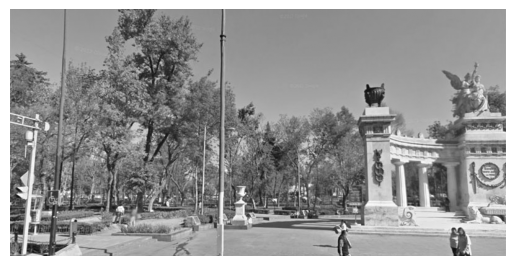

In [5]:
image_1 = cv2.imread("Image_1.jpg", cv2.IMREAD_GRAYSCALE).astype(np.double)
#dog_img = np.asarray(Image.open('dog.jpg'))

displayImg(image_1)

In [6]:
image_1.shape

(398, 800)

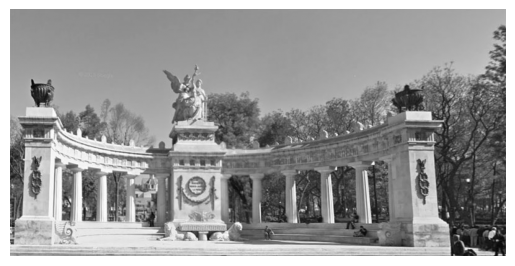

In [24]:
image_2 = cv2.imread("Image_2.jpg", cv2.IMREAD_GRAYSCALE).astype(np.double)

displayImg(image_2)

### 2. Feature Detection:

* Detect feature points in both images using the Harris detector.
* Do not use built-in functions for this step.

In [8]:
# Define function for padding images
def pad_image(image, kernel):
  width = kernel.shape[0] // 2
  if kernel.ndim == 2:
    height = kernel.shape[1] // 2
  else:
    height = 0

  padding = ((width, width), (height, height))
  padded_img = np.pad(image, padding, mode='constant')
  return padded_img

#padded_img = pad_image(input_img, input_kernel)


In [9]:
# Function to perform convolution on padded image and flipped Kernel
def convolution(image, kernel):
  # Pad Image if pad_input = True
  image = pad_image(image, kernel)

  # Get dimensions of input and kernel
  input_x, input_y = image.shape[0], image.shape[1]
  kernel_x, kernel_y = kernel.shape[0], kernel.shape[1]

  # Calculate the size of the output image
  output_x = input_x - kernel_x + 1
  output_y = input_y - kernel_y + 1

  output_img = np.zeros((output_x, output_y))
  # Convolve a grayscale image
  for i in range(output_x):
      for j in range(output_y):
        # Extract the region of the input matrix covered by the kernel
        region = image[i:i+kernel_x, j:j+kernel_y]

        # Apply element-wise multiplication and sum the result
        output_img[i, j] = np.sum(region * kernel)

  return output_img

In [10]:
sobel_x = np.array([[1, 0, -1],
          [2, 0, -2],
          [1, 0, -1]])

In [11]:
sobel_y = np.array([[1, 2, 1],
          [0, 0, 0],
          [-1, -2, -1]])

In [12]:
# Gaussian Kernel
gaussian_kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]])/16

In [13]:
# Detect Corners
def get_harris_corners(image, k):
    # Calculate Gx and Gy for Image
    gx = convolution(image, sobel_x)
    gy = convolution(image, sobel_y)

    IxIx = convolution(gx * gx, gaussian_kernel)
    IyIy = convolution(gy * gy, gaussian_kernel)
    IxIy = convolution(gx * gy, gaussian_kernel)

    det = (IxIx * IyIy) - (IxIy * IxIy)
    trace = IxIx + IyIy
    # Calculate Harris Corner Response
    R = det - k * (trace * trace)
    return R


In [14]:
def non_maximal_suppression(harris_response, n_size):
  output = np.copy(harris_response)
  rows = harris_response.shape[0]
  cols = harris_response.shape[1]
  for i in range(rows):
    for j in range(cols):
      # If it's an edge, suppress it
      if harris_response[i, j] < 0:
        output[i,j] = 0

      if harris_response[i, j] > 0:
          # Extract neighborhood based on n_size
          row_start = max(0, i - n_size // 2)
          row_end = min(rows, i + n_size // 2 + 1)
          col_start = max(0, j - n_size // 2)
          col_end = min(cols, j + n_size // 2 + 1)
          neighborhood = harris_response[row_start:row_end, col_start:col_end]

          # Get max value in the neighborhood
          max_val = np.max(neighborhood)

          # If the current pixel is less than max_val, suppress it
          if harris_response[i, j] < max_val:
              output[i, j] = 0
  return output

In [15]:
# Plot corners on the image
def plot_corners(image, nms_response):
  plt.imshow(image, cmap='gray')
  # Overlay the corner points
  y, x = np.where(nms_response > 1)
  plt.plot(x, y, 'r.', markersize=2)
  plt.axis('off')
  plt.show()

In [16]:
def detect_corners(image, k, n_size):
  harris_response = get_harris_corners(image, k)
  output = non_maximal_suppression(harris_response, n_size)
  threshold = 0.05 * output.max()
  output[output < threshold] = 0
  plot_corners(image, output)


In [17]:
k= 0.04
neighboor_size = 7

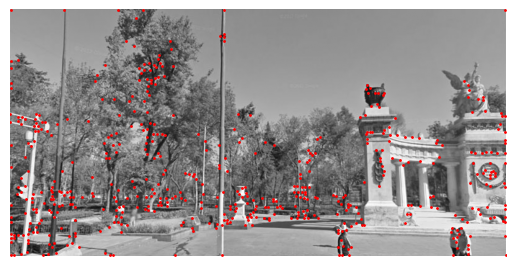

In [20]:
detect_corners(image_1, k, neighboor_size)

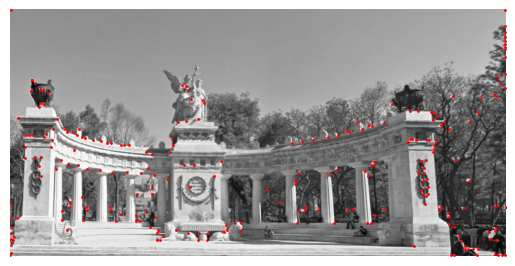

In [26]:
detect_corners(image_2, k, neighboor_size)

### 3. Descriptor Extraction:
* Extract local neighborhoods around each detected keypoint.
* Flatten pixel values to form one-dimensional descriptors.
* The neighborhood size is a hyperparameter-choose accordingly.
* Optionally, SIFT descriptors can be used.

In [27]:
def extract_sift_descriptors(image):
    # Instantiate skimage SIFT
    sift = SIFT()
    sift.detect_and_extract(image)
    keypoints = sift.keypoints
    descriptors = sift.descriptors
    return keypoints, descriptors

In [28]:
kp1, desc1 = extract_sift_descriptors(image_1)
kp2, desc2 = extract_sift_descriptors(image_2)

### 4. Computing Descriptor Distances:
* Calculate the distance between descriptors from both images.
* Use **scipy.spatial.distance.cdist(X, Y, 'sqeuclidean')** for Euclidean distances.
* If not using SIFT, try normalized correlation or normalized Euclidean distance.

### 5. Selecting Putative Matches:
* Identify potential matches based on descriptor distance matrix.
* Either:
  * Select all pairs below a threshold, or
  * Choose the top few hundred closest descriptor pairs.

In [29]:
def compute_descriptor_dist(desc1, desc2, top_k=300):
    # Calculate Euclidean Distance between discriptors
    d2 = distance.cdist(desc1, desc2, 'sqeuclidean')

    # Flatten into list of (i, j, dist)
    N1, N2 = d2.shape
    matches = []
    for i in range(N1):
        for j in range(N2):
            matches.append((i, j, d2[i, j]))
    # Sort by distance
    matches.sort(key=lambda x: x[2])
    # Pick top_k
    matches = matches[:top_k]
    # Return only (i,j) pairs
    return [(i, j) for (i, j, _) in matches]

### 6. Homography Estimation:
* Use RANSAC to estimate the homography between the images.
* Refer to lecture slides, online tutorials, or YouTube for guidance.
* Built-in functions may be used for this step.

### 7. Parameter Tuning:
* Experiment with different RANSAC parameters (e.g., number of iterations inlier threshold).
* Optimize for the best alignment results.



### 8. Image Warping:
* Apply the estimated transformation to align the images.
* Use **skimage.transform.ProjectiveTransform** and **skimage.transform.warp** in Python.


### 9. Panorama Creation:
* Create a canvas large enough for the stitched panorama.
* Composite the images, blending overlapping areas using:
  * Pixel averaging, or
  * Selecting pixel values from one image.